<a href="https://colab.research.google.com/github/faizanhemotra/CE888/blob/main/Project/Emoji_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests

In [ ]:
def shape_data(feature, label):
    '''Returns number of rows for feature and label'''
    return len(feature.splitlines()), len(label.splitlines())

In [ ]:
emoji_train_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emoji/train_text.txt'
emoji_train = requests.get(emoji_train_url)
emoji_train_labels_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emoji/train_labels.txt'
emoji_train_labels = requests.get(emoji_train_labels_url)
print('Emoji Training, Label')
shape_data(emoji_train.text, emoji_train_labels.text)

Emoji Training, Label


(45000, 45000)

In [ ]:
emoji_val_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emoji/val_text.txt'
emoji_val = requests.get(emoji_val_url)
emoji_val_labels_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emoji/val_labels.txt'
emoji_val_labels = requests.get(emoji_val_labels_url)
print('Emoji Validation, Label')
shape_data(emoji_val.text, emoji_val_labels.text)

Emoji Validation, Label


(5000, 5000)

In [ ]:
emoji_test_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emoji/test_text.txt'
emoji_test = requests.get(emoji_test_url)
emoji_test_labels_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emoji/test_labels.txt'
emoji_test_labels = requests.get(emoji_test_labels_url)
print('Emoji Test, Label')
shape_data(emoji_test.text, emoji_test_labels.text)

Emoji Test, Label


(50000, 50000)

### Labels

In [ ]:
emoji_train_distr = list()
for label in emoji_train_labels.text.splitlines():
    emoji_train_distr.append(int(label))

In [ ]:
emoji_val_distr = list()
for label in emoji_val_labels.text.splitlines():
    emoji_val_distr.append(int(label))
    
emoji_test_distr = list()
for label in emoji_test_labels.text.splitlines():
    emoji_test_distr.append(int(label))

## Removal of links

In [ ]:
def linkremover(text):
    '''Removes t.co and instagram.com links from the data'''
    tco = r'https?://t.co/[\w]{10}'
    insta = r'https?://(www.)?instagram.com/p/[-\w]{11}/?'
    if (re.findall(tco + '|' + insta, text) != []):
        final = re.sub(tco + '|' + insta, '', text)
        return final
    else:
        print('No links')
    return text    
emoji_tr = linkremover(emoji_train.text)
emoji_v = linkremover(emoji_val.text)
emoji_te = linkremover(emoji_test.text)

## Conversion to DataFrame

In [ ]:
def convdf(col1, col2, label1, label2='Label'):
    '''converts data to dataframe'''
    return pd.DataFrame({label1: list(col1.splitlines()), label2: np.array(col2)})

In [ ]:
df_emoji_tr = convdf(emoji_tr, emoji_train_distr, 'Emoji')
df_emoji_v = convdf(emoji_v, emoji_val_distr, 'Emoji')
df_emoji_te = convdf(emoji_te, emoji_test_distr, 'Emoji')

In [ ]:
df_emoji_tr.head()

,Emoji,Label
0,Sunday afternoon walking through Venice in the...,12
1,Time for some BBQ and whiskey libations. Chomp...,19
2,Love love love all these people ️ ️ ️ #friends...,0
3,"️ ️ ️ ️ @ Toys""R""Us",0
4,Man these are the funniest kids ever!! That fa...,2


In [ ]:
print(df_emoji_tr.isna().values.any())
print(df_emoji_v.isna().values.any())
print(df_emoji_te.isna().values.any())

False
False
False


## Training 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.svm import LinearSVC
pipeline = Pipeline([('union', FeatureUnion([
                                             ('word_vec', CountVectorizer(analyzer='word', ngram_range=(1,4), min_df=2)),
                                             ('char_vec', CountVectorizer(analyzer='char', ngram_range=(1,6)))
                                             ])),
                     ('transform',TfidfTransformer()),
                     ('clf', LinearSVC(C=0.10, class_weight='balanced'))])

In [ ]:
from sklearn.model_selection import GridSearchCV

polynomial_pipeline = Pipeline([
    ('union', FeatureUnion([('word_vec', CountVectorizer()),
                            ('char_vec', CountVectorizer())])),
    ('transform', TfidfTransformer()),
    ('clf', LinearSVC())
])
param_grid = {
    'union__word_vec__strip_accents': ['ascii', None],
    'union__word_vec__binary': [True, False],
    'union__char_vec__binary': [True, False],
    'clf__loss': ['hinge', 'squared_hinge'],
}
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='f1_macro', n_jobs=1, verbose=2)
grid_search.fit(df_emoji_tr['Emoji'], df_emoji_tr['Label'])

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] clf__loss=hinge, union__char_vec__binary=True, union__word_vec__binary=True, union__word_vec__strip_accents=ascii 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__loss=hinge, union__char_vec__binary=True, union__word_vec__binary=True, union__word_vec__strip_accents=ascii, total= 1.8min
[CV] clf__loss=hinge, union__char_vec__binary=True, union__word_vec__binary=True, union__word_vec__strip_accents=ascii 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV]  clf__loss=hinge, union__char_vec__binary=True, union__word_vec__binary=True, union__word_vec__strip_accents=ascii, total= 1.8min
[CV] clf__loss=hinge, union__char_vec__binary=True, union__word_vec__binary=True, union__word_vec__strip_accents=ascii 
[CV]  clf__loss=hinge, union__char_vec__binary=True, union__word_vec__binary=True, union__word_vec__strip_accents=ascii, total= 1.7min
[CV] clf__loss=hinge, union__char_vec__binary=True, union__word_vec__binary=True, union__word_vec__strip_accents=None 
[CV]  clf__loss=hinge, union__char_vec__binary=True, union__word_vec__binary=True, union__word_vec__strip_accents=None, total= 1.6min
[CV] clf__loss=hinge, union__char_vec__binary=True, union__word_vec__binary=True, union__word_vec__strip_accents=None 
[CV]  clf__loss=hinge, union__char_vec__binary=True, union__word_vec__binary=True, union__word_vec__strip_accents=None, total= 1.8min
[CV] clf__loss=hinge, union__char_vec__binary=True, union__word_vec__binary=True, union__word_vec__strip

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 68.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('union',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('word_vec',
                                                                        CountVectorizer(analyzer='word',
                                                                                        binary=False,
                                                                                        decode_error='strict',
                                                                                        dtype=<class 'numpy.int64'>,
                                                                                        encoding='utf-8',
                                                                                        input='content',
                                                                          

In [ ]:
grid_search.best_params_

{'clf__loss': 'squared_hinge',
 'union__char_vec__binary': True,
 'union__word_vec__binary': False,
 'union__word_vec__strip_accents': 'ascii'}

In [ ]:
df = pd.DataFrame(grid_search.cv_results_)

In [ ]:
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__loss,param_union__char_vec__binary,param_union__word_vec__binary,param_union__word_vec__strip_accents,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,97.415430,2.971225,7.881915,0.151313,hinge,True,True,ascii,"{'clf__loss': 'hinge', 'union__char_vec__binar...",0.249413,0.253123,0.257090,0.253209,0.003135,9
1,92.247740,6.348468,7.899790,0.156847,hinge,True,True,None,"{'clf__loss': 'hinge', 'union__char_vec__binar...",0.249450,0.253073,0.257000,0.253174,0.003083,10
2,95.434473,2.469926,8.088680,0.108951,hinge,True,False,ascii,"{'clf__loss': 'hinge', 'union__char_vec__binar...",0.249643,0.252986,0.256700,0.253110,0.002882,11
3,99.689392,2.754564,7.957735,0.160074,hinge,True,False,None,"{'clf__loss': 'hinge', 'union__char_vec__binar...",0.249345,0.253056,0.256712,0.253037,0.003007,12
4,118.717531,7.580775,8.119781,0.214536,hinge,False,True,ascii,"{'clf__loss': 'hinge', 'union__char_vec__binar...",0.245584,0.251393,0.251864,0.249614,0.002856,14
5,119.033831,4.884475,8.020974,0.088565,hinge,False,True,None,"{'clf__loss': 'hinge', 'union__char_vec__binar...",0.245262,0.251555,0.252374,0.249730,0.003177,13
6,124.010736,6.487004,8.197656,0.073878,hinge,False,False,ascii,"{'clf__loss': 'hinge', 'union__char_vec__binar...",0.245159,0.250379,0.252069,0.249203,0.002941,16
7,123.681861,7.959886,8.025447,0.051023,hinge,False,False,None,"{'clf__loss': 'hinge', 'union__char_vec__binar...",0.245609,0.250454,0.252645,0.249569,0.002940,15
8,45.221327,0.582928,8.000181,0.221197,squared_hinge,True,True,ascii,"{'clf__loss': 'squared_hinge', 'union__char_ve...",0.278574,0.279936,0.288356,0.282289,0.004326,4
9,46.517774,0.645419,8.231815,0.147774,squared_hinge,True,True,None,"{'clf__loss': 'squared_hinge', 'union__char_ve...",0.278763,0.279936,0.288322,0.282340,0.004257,3


In [ ]:
grid_search.best_score_

0.2827918286503779

## Evaluations 

In [ ]:
from sklearn.metrics import f1_score, plot_confusion_matrix
f1 = f1_score(df_emoji_v['Label'], grid_search.predict(df_emoji_v['Emoji'].values), average='macro')
f1

0.25514089009074714

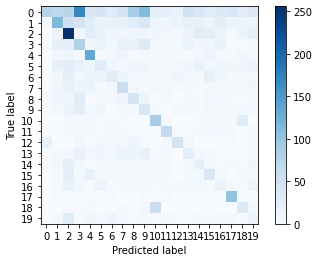

In [ ]:
plot_confusion_matrix(grid_search, df_emoji_v['Emoji'], df_emoji_v['Label'], include_values=False, cmap=plt.cm.Blues)
plt.show()

In [ ]:
f1 = f1_score(df_emoji_te['Label'], grid_search.predict(df_emoji_te['Emoji']), average='macro')
f1

0.29421443261740116

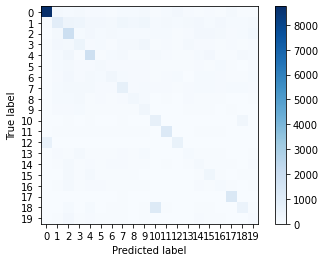

In [ ]:
plot_confusion_matrix(grid_search, df_emoji_te['Emoji'], df_emoji_te['Label'], include_values=False, cmap=plt.cm.Blues)
plt.show()